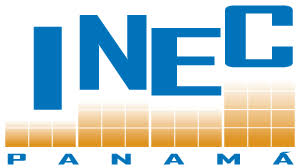

# Proyección Nowcast

Esta libreria construye la proyección de nowcast usando la metodología especificada en el punto punto 2.2 (Factores dinámicos y regresión en dos etapas) del informe. Se busca obtener proyecciones trimestrales usando informacion mensual y que se pueda manejar el problema de informacion faltante.

###### Primera etapa
Este método se basa en Stock y Watson (1989). Se asume que la información disponible al periodo t se encuentra generada por factores subyacentes:

$$X_t=\lambda F_t+η_t$$

Donde:

$X_t$: Variables disponibles
$F_t$: Factor subyacente
$η_t$: Error

###### Segunda etapa

Se estima una segunda etapa, donde el PIB ($y_t$) depende de este factor $F_t$:

$$y_t= \gamma + \kappa F_t+\epsilon_t$$


### Librerías y rutas

In [1]:
import pykalman as kalman
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos
from ipynb.fs.defs.m4nowcast_kalman import kalman_fed_nyc

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import pickle
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_nowcast/'


### Construcción de base de datos

In [3]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

C:\Users\eo\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\eo\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Importando resultados de la estimacion

### Primera etapa

Parámetros de la primera etapa

In [4]:
with open(rutaModelos + 'nowcast_model.pkl', 'rb') as file:
    kalman = pickle.load(file)

In [5]:
X,y,n_factors,params,initial_state_mean,initial_state_covariance, _, _ = kalman

Estimación de la primera etapa

In [6]:
_, _, bd_S, bd_F, bd_P, bd, bd_data = kalman_fed_nyc(bd_all,X,y,n_factors,params,
                                             initial_state_mean,initial_state_covariance,0)

### Segunda etapa

Parámetros de la segunda etapa

In [7]:
with open(rutaModelos + 'nowcast_2stage.pkl', 'rb') as file:
    Z, Linear_ = pickle.load(file)

Estimación de la segunda etapa

In [ ]:
bd_S = bd_S.loc[bd_S[bd_S.index.month % 3== 1].index[0]:,:]

In [8]:
bd_2etapa = bd_S[bd_S.columns[0]].groupby(pd.Grouper(freq = 'Q')).aggregate([lambda y: y[0], lambda y: y[1], lambda y: y[2]]).rename(columns = lambda y: y[8])
X_ = bd_2etapa.columns

bd_proyeccion = pd.DataFrame(Linear_.predict(bd_2etapa), index =  bd_2etapa.index, columns = ['Proyeccion'])
bd_proyeccion = bd_proyeccion.join(bd_all[Z].groupby(pd.Grouper(freq='Q')).sum())

bd_proyeccion[bd_proyeccion[Z] == 0] = np.nan

Exportando resultados a excel

In [9]:
 with pd.ExcelWriter(rutaDestino + 'baseNowcasting.xlsx') as writer:
        bd_proyeccion.to_excel(writer, sheet_name = 'Trimestral')

### Proyecciones

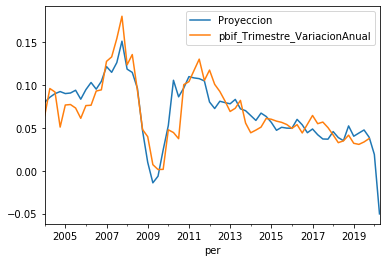

In [10]:
bd_proyeccion.plot()

In [11]:
bd_proyeccion

,Proyeccion,pbif_Trimestre_VariacionAnual
per,,
2004-03-31,0.079916,0.064292
2004-06-30,0.085833,0.096026
2004-09-30,0.090015,0.091927
2004-12-31,0.092454,0.050969
2005-03-31,0.090120,0.076754
...,...,...
2019-06-30,0.044006,0.030771
2019-09-30,0.047602,0.033609
2019-12-31,0.039021,0.037627
